In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve,roc_auc_score,fbeta_score,recall_score
from sklearn.metrics import plot_precision_recall_curve,average_precision_score,f1_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC

sns.set(style="whitegrid")
np.random.seed(203)


In [2]:
raw_features=pd.read_csv("elliptic_txs_features.csv")
raw_classes=pd.read_csv("elliptic_txs_classes.csv")
raw_edgelist=pd.read_csv("elliptic_txs_edgelist.csv")

In [3]:
raw_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [4]:
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


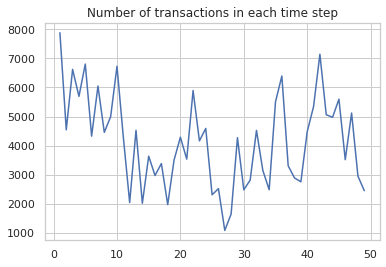

In [5]:
raw_features['time'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step');

In [6]:
raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')

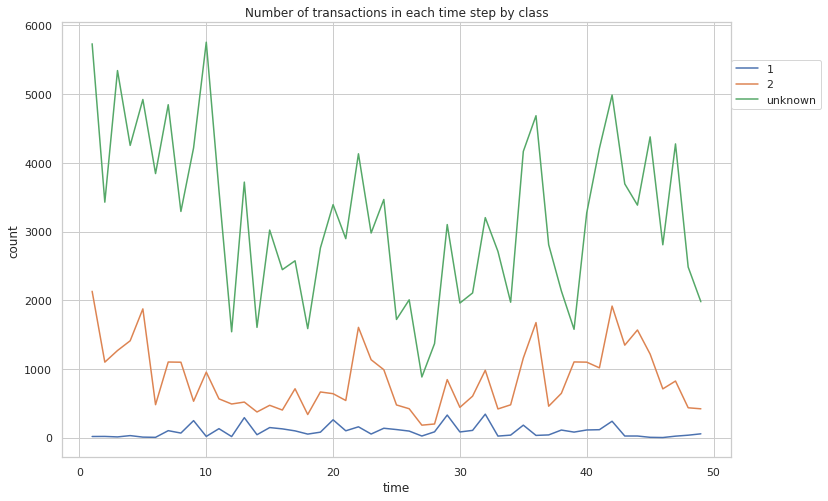

In [7]:
plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time', y='count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

In [8]:
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,unknown
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,230459870,unknown


In [9]:
raw_features=raw_features.rename(columns={"class":"Class"})

In [10]:
cleaned_df = raw_features.copy()

cleaned_df.pop('time')

cleaned_df.pop('txId')

cleaned_df.pop('id')

0           5530458
1         232022460
2         232438397
3         230460314
4         230459870
            ...    
203763    173077460
203764    158577750
203765    158375402
203766    158654197
203767    157597225
Name: id, Length: 203768, dtype: int64

In [11]:
cleaned_df['Class'].replace({"unknown": "-1"}, inplace=True)
cleaned_df['Class'].replace({"1": "1"}, inplace=True)
cleaned_df['Class'].replace({"2": "0"}, inplace=True)
cleaned_df['Class'] = pd.to_numeric(cleaned_df['Class'])

In [12]:
def rand_bin_array(K, N):
    arr = np.zeros(N,int)

    arr[:K]  = int( 1)
    np.random.shuffle(arr)
    return arr

In [13]:
prueba_0=cleaned_df[cleaned_df['Class']==0] 
prueba_0

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
8,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
9,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
10,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
15,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,-0.047227,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203739,-0.133841,-0.109114,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.123596,-0.129972,-0.049707,...,1.467840,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
203749,-0.172455,-0.138626,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163104,-0.168926,-0.049707,...,-0.569462,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
203751,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,-0.149635,-0.155646,-0.049707,...,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035,0
203753,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163622,-0.169437,-0.049707,...,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792,0


In [14]:
prueba_1=cleaned_df[cleaned_df['Class']==1] 
prueba_1

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
906,-0.172669,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163319,-0.169138,-0.049707,...,-0.285627,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
1360,-0.164417,0.048298,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163580,-0.164278,-0.022718,...,-0.500080,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,1
2717,-0.164272,0.048298,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163191,-0.163923,-0.016812,...,1.757982,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
2814,-0.168195,0.048298,-1.201369,-0.046932,-0.063725,-0.029140,-0.061584,-0.163574,-0.164695,-0.006824,...,-0.600999,0.241128,0.241406,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,1
3422,-0.169109,0.048298,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.162900,-0.166282,-0.027389,...,0.584799,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203684,-0.172493,-0.090143,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163588,-0.169212,-0.048440,...,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203707,-0.172795,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163639,-0.169286,-0.048469,...,-0.090097,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203735,-0.170895,0.071985,1.573595,0.328255,-0.043875,0.390171,-0.061584,-0.163629,-0.168980,-0.047736,...,1.575067,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203758,-0.170412,-0.078164,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163631,-0.167106,-0.032993,...,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1


In [15]:
prueba=cleaned_df[cleaned_df['Class']==-1]  
prueba

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,-1
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,-1
4,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,-1
5,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,-0.167726,-0.049707,...,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203761,-0.172974,-0.156732,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163636,-0.169451,-0.049707,...,0.647874,0.241128,0.241406,7.165536,1.085202,-0.131155,5.157442,-0.120613,-0.119792,-1
203763,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,-0.142008,-0.049707,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
203764,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,-0.162334,-0.049707,...,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,-1
203766,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,-0.169317,-0.049707,...,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,-1


In [16]:
prueba['Class']=rand_bin_array(15720,157204)  

In [17]:
vertical = pd.concat([prueba, prueba_0,prueba_1], axis=0) 

In [18]:
vertical=vertical.sort_index()  
vertical

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,...,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,0
4,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,...,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203763,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,-0.142008,-0.049707,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
203764,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,-0.162334,-0.049707,...,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,0
203765,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,-0.168778,-0.045389,...,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203766,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,-0.169317,-0.049707,...,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,0


In [19]:
y=vertical['Class']

In [20]:
data= vertical.copy()

In [21]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,183503,90.05
1,1,20265,9.95


In [22]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

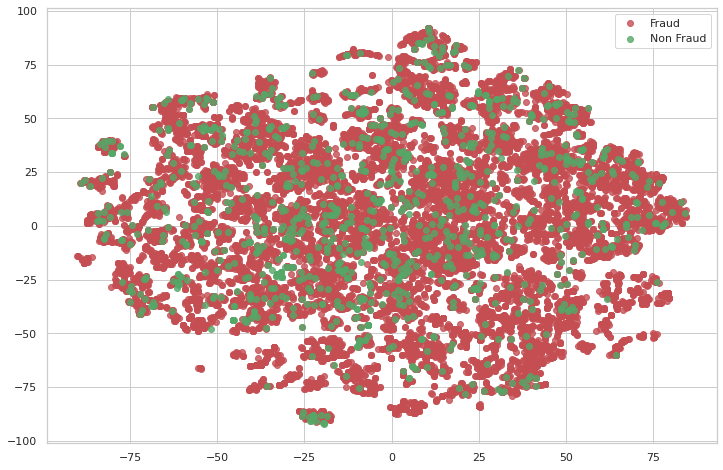

In [23]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [24]:
 
input_layer = Input(shape=(X.shape[1],))

encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)


decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

output_layer = Dense(X.shape[1], activation='relu')(decoded)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [26]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [27]:
%%time
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 1s 932us/sample - loss: 0.1239 - val_loss: 0.1210
Epoch 2/10
1600/1600 [==============================] - 0s 31us/sample - loss: 0.1238 - val_loss: 0.1210
Epoch 3/10
1600/1600 [==============================] - 0s 22us/sample - loss: 0.1237 - val_loss: 0.1209
Epoch 4/10
1600/1600 [==============================] - 0s 25us/sample - loss: 0.1237 - val_loss: 0.1209
Epoch 5/10
1600/1600 [==============================] - 0s 39us/sample - loss: 0.1236 - val_loss: 0.1208
Epoch 6/10
1600/1600 [==============================] - 0s 29us/sample - loss: 0.1236 - val_loss: 0.1208
Epoch 7/10
1600/1600 [==============================] - 0s 33us/sample - loss: 0.1235 - val_loss: 0.1207
Epoch 8/10
1600/1600 [==============================] - 0s 21us/sample - loss: 0.1234 - val_loss: 0.1206
Epoch 9/10
1600/1600 [==============================] - 0s 35us/sample - loss: 0.1234 - val_loss: 0.1206
Epoch 1

In [28]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [29]:
norm_hid_rep = hidden_representation.predict(x_norm[:4000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

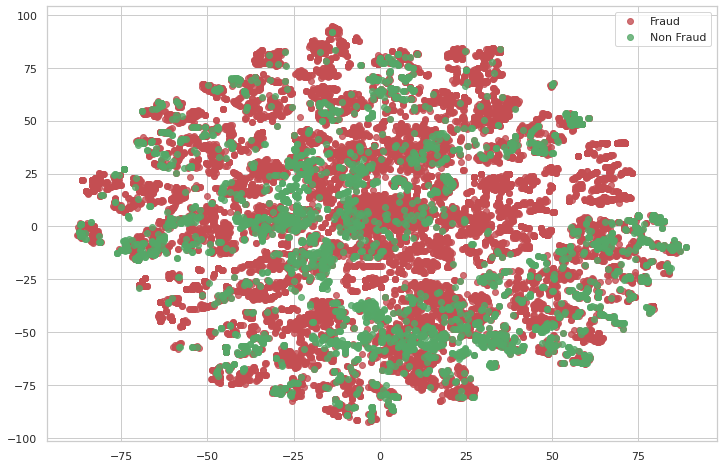

In [30]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

In [31]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs",max_iter=4000).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.66      0.31      0.42       984
         1.0       0.88      0.97      0.92      5083

    accuracy                           0.86      6067
   macro avg       0.77      0.64      0.67      6067
weighted avg       0.84      0.86      0.84      6067


Accuracy Score:  0.8625350255480468


In [32]:
cnf_matrix = metrics.confusion_matrix(val_y, pred_y)
cnf_matrix

array([[ 308,  676],
       [ 158, 4925]])

Text(0.5, 257.44, 'Predicted label')

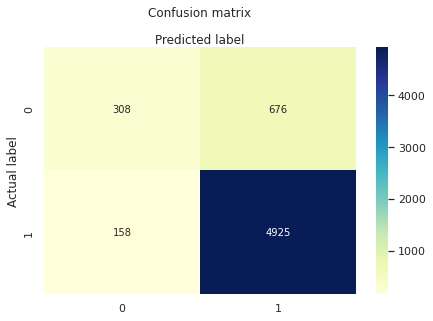

In [37]:
%matplotlib inline

class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

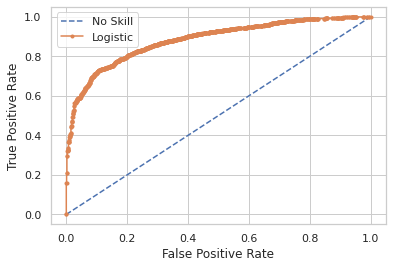

In [38]:
yhat = clf.predict_proba(val_x)
pos_probs = yhat[:, 1]
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(val_y, pos_probs)
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [40]:
ROC_AUC=roc_auc_score(val_y, clf.predict_proba(val_x)[:, 1])
print('ROC_AUC: {0:0.2f}'.format(ROC_AUC))

ROC_AUC: 0.88


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

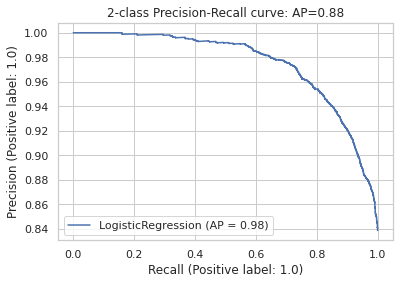

In [45]:
disp = plot_precision_recall_curve(clf, val_x, val_y)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))